# 大模型技术与应用第一次作业
## 1. 作业要求
基于课程网站上的英文数据training-monolingual-news-commentary ，利
用subword切分方法对英文数据进行切分，分别设置词表规模为1000、
3000和5000，统计计算切分后的数据压缩率。
## 2. 方法介绍
使用os库读取文件夹中的英文数据，使用`BPE`方法对英文数据进行切分，统计切分后的数据压缩率
### 2.1 BPE方法（Byte-Pair Encoding）
`BPE`方法是一种基于统计的数据压缩算法，它的基本思想是将数据中的常用字符组合成一个新的字符，这样可以减少数据的冗余度，从而达到压缩数据的目的

具体而言：

我们从⼀组基本符号开始，迭代寻找语料库中两个相邻词元，并将它们替换为新的词元

选择的原则为：计算两个连续词元的共现频率，即选择最频繁的⼀对词元合并

终止原则为达到预先设定的词表规模
### 2.2 数据压缩率
在我们的实验中，数据压缩率的计算公式为：
$$压缩比 = \frac{utf-8字节数}{分词之后的词元数} $$
通过计算压缩比，我们可以量化`BPE`方法对数据压缩的效果
## 3. 实验过程
### 读取数据
注意到我们的英文数据集是一个tar文件，我们首先对这个文件进行解压缩
```shell
tar -xvf ./data/training-monolingual-news-comm.tar -C ./data/
```
得到了一个文件夹，里面有很多的文本文件，我们可以进一步使用python的os库来读取这些文件
但是按照要求我们这次只对英文数据进行处理，也就是说我们只需要处理文件名中后缀`en`的文件，读取出来之后我们进行适当的数据清洗，并从中提取出英文词表，这里直接使用counter库来统计词频，并且在每一个词的首尾加上`<w>`标记，这样我们就可以使用`BPE`方法来进行切分了
### 使用subword切分方法对英文数据进行切分
我们使用`BPE`方法进行切分，原理已经在上文中回顾过了。
bpe相关的实现代码放在了`./utils/bpe.py`中，我们可以直接调用这个文件中的`bpe`类来进行切分

在其中的`init`函数中我们读取了文件，并且在文件中进行了一定的数据清洗和加工，在每一个词中我们引入进了`<\w>`标记，这样我们初始化了原来词表的corpus信息，这里使用了tuple这一数据结构存储，目的在于更好的服务于后续在`get_pair_stats`中的统计计算

在`get_pair_stats`中我们统计了词表中的词元对的频率，这里我们使用了`defaultdict`这一数据结构，具体实现的时候使用了`counter`，这样在后续选择最大频率的词元对的时候我们可以调用counter的`most_common`方法
```python
def get_pair_stats(self) -> Tuple[Tuple[str, str], int]:
    '''
    从corpus中获取pair的统计信息
    '''
    pairs = Counter()
    for word, freq in self.corpus.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[(symbols[i], symbols[i + 1])] += freq
    return pairs
```

在`merge_vocab`中我们选择了最大频率的词元对进行合并，并且更新corpus信息，这样我们就可以在下一次迭代中继续进行统计计算
```python
def merge_vocab(self, pairs):
    '''
    将pair合并到vocab中
    '''
    pair = pairs.most_common(1)[0][0]
    new_corpus = Counter()
    # 待替换的模式串
    pattern = re.escape(' '.join(pair))
    # 替换后的串
    replacement = ''.join(pair)
    for word in self.corpus:
        new_word = re.sub(pattern, replacement, word)
        new_corpus[new_word] = self.corpus[word]
    self.corpus = new_corpus
```

在每一次迭代中我们需要调用`update_vocab`方法来更新词表，这里我们为了精确更新需要遍历整个corpus，如果有性能问题可以考虑非准确的统计方法
```python
def update_vocab(self):
    '''
    更新vocab
    '''
    vocab = set()
    for word in self.corpus:
        symbols = word.split()
        for symbol in symbols:
            vocab.add(symbol)
    self.vocab = vocab
```

在`solution`中我们进行迭代，直到达到预设的词表规模，这样我们就得到了我们的词表，如果还有后续任务的需要我们可以应用保存好的词表编写`encode`和`decode`方法来进行编码和解码（这次任务中未涉及）

### 计算压缩比
调用编写好的`./utils/compress_rate.py`文件中的`compress_rate`函数，传入词表和corpus信息，我们就可以得到压缩比了
```python
def compress_rate(vocab: Set[str], corpus: Dict[str, int]) -> float:
    '''
    计算压缩比
    '''
    # 计算utf-8字节数
    utf8_bytes = 0
    for word in corpus:
        utf8_bytes += len(word.encode('utf-8'))
    # 计算分词之后的词元数
    subwords = 0
    for word in corpus:
        symbols = word.split()
        subwords += len(symbols)
    return utf8_bytes / subwords
```
### 编写demo文件
在demo中我们调用这些编写好的函数，完成整个任务，并且适当地调用visualization相关的库来可视化对比分析结果


In [1]:
import os
from utils.bpe import bpe
from utils.compression_ratio import compression_ratio
vocab_sizes = [1000,3000,5000]
path = './data/training-monolingual/news-commentary-v6.en'
dir = './output'
ratios = []
if not os.path.exists(dir):
    os.makedirs(dir)
for vocab_size in vocab_sizes:
    bpe_instance = bpe(path, vocab_size)
    corpus, vocab = bpe_instance.solution()
    original_corpus = bpe_instance.original_corpus
    compression_ratio_instance = compression_ratio()
    ratio = compression_ratio_instance.solution(original_corpus, corpus)
    ratios.append(ratio)
    print(f'Vocab size: {vocab_size}, Compression Ratio: {ratio}')
    bpe_instance.save(dir)

Vocab size: 1000, Compression Ratio: 1.8254538006727201
Vocab size: 3000, Compression Ratio: 2.0915950937345222
Vocab size: 5000, Compression Ratio: 2.294968576334236


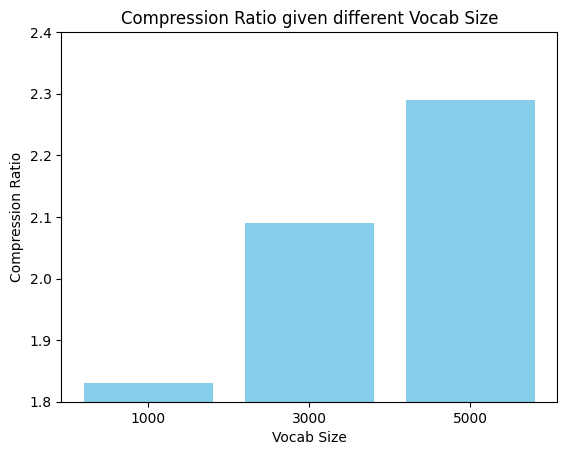

In [33]:
# 可视化
import matplotlib.pyplot as plt
# 使用直方图
a = [1, 2, 3]
b = [1.83, 2.09, 2.29]
plt.bar(a, b, color='skyblue')
plt.xticks(a, ['1000', '3000', '5000'])
plt.xlabel('Vocab Size')
plt.ylabel('Compression Ratio')
plt.ylim(1.8, 2.4)
plt.title('Compression Ratio given different Vocab Size')
plt.savefig('./output/compression_ratio.png')
plt.show()

Linear Regression: y = 0.00011737869391537865x + 1.7185364085010235
Correlation Coefficient: 0.9970345608249087
R-squared: 0.9940779154793186


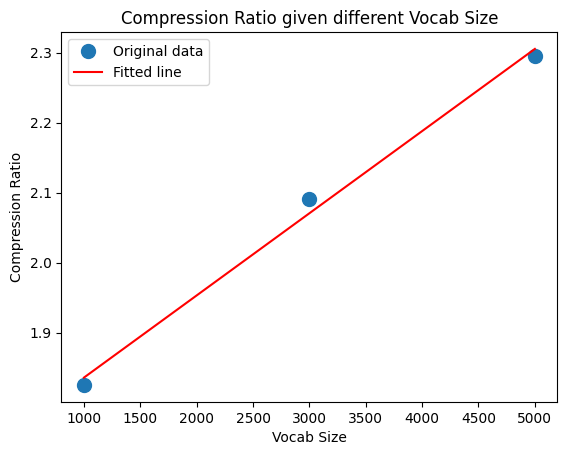

In [35]:
# 分析线性性
import numpy as np
x = np.array(vocab_sizes)
y = np.array(ratios)
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

print(f'Linear Regression: y = {m}x + {c}')
print(f'Correlation Coefficient: {correlation_xy}')
print(f'R-squared: {r_squared}')
plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.xlabel('Vocab Size')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio given different Vocab Size')
plt.legend()
plt.savefig('./output/compression_ratio_linear_regression.png')
plt.show()

## 4. 实验结果及分析
### 不同词表规模对应的压缩比 
我们分别对词表规模为1000、3000和5000的情况进行了实验，得到了如下的结果：
```shell
词表规模为1000时，压缩比为1.8254538006727201
词表规模为3000时，压缩比为2.0915950937345222
词表规模为5000时，压缩比为2.294968576334236
```
从中我们可以看到，随着词表规模的增大，压缩比也在增大，这是因为词表规模越大，我们可以更好地对数据进行压缩，减少数据的冗余度，从而达到更好的压缩效果，达到了我们期望的压缩信息的目的，并且使用子词压缩的方法我们缓解以词语为单元的数据稀疏和语义鸿沟问题，避免以字符为单元的低效和建模难度⼤的问题。

### 词表规模和压缩比之间大致呈现线性关系 
进一步我们用`numpy`中的方法进行了线性拟合，得到了如下的结果：
```shell
Linear Regression: y = 0.00011737869391537865x + 1.7185364085010235
Correlation Coefficient: 0.9970345608249087
R-squared: 0.9940779154793186
```
从中我们可以看到，线性回归的拟合效果很好，相关系数和R平方值都很高，这说明了词表规模和压缩比之间具有良好的线性关系，然而这一部分的规律的探索我们在这一步就浅尝辄止了，有待进一步的深入研究

### 实验不足
实验中缺乏更加精准的数据清洗手段，由于程序中储存使用的是utf-8编码，这使得我们最终打印出来的vocab中包含有utf-8编码方式下的乱码。粗略的清洗手段对于我们验证bpe编码的有效性已经足够了，但是如果有下游任务的需要则需要更加精确的数据清洗手段

在这个实验中我们只将词表规模设置在1000，3000，5000，要更加深入的探讨词表规模和压缩比之间的关系，我们需要更多的词表规模的数据。